In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np

from toy_plot_helpers import ToyPlot

In [2]:
import openpathsampling.dynamics.toy as toys

plot = ToyPlot()
pes = (
    toys.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [-0.5, 0.5]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

plot.contour_range = np.arange(-1.5, 1.0, 0.1)

topology=toys.Topology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    topology=topology
)

integ = toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.Engine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template
paths.PathMover.engine = toy_eng

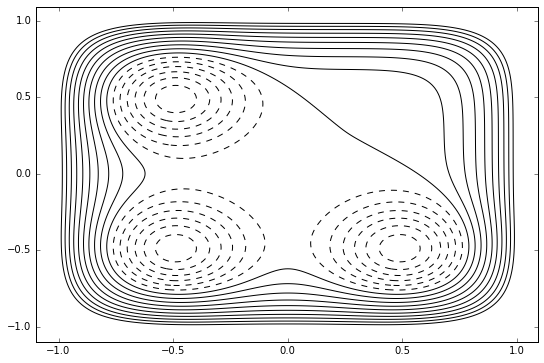

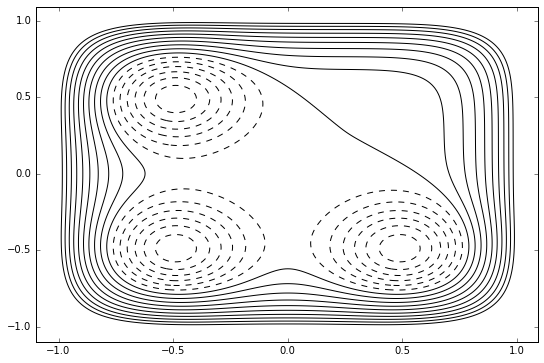

In [3]:
plot.add_pes(pes)
plot.plot()

In [4]:
def xval(snapshot):
    return snapshot.xyz[0][0]

def xprime(snapshot):
    # this only exists until we set up the ability for the order parameter to decrease
    return -snapshot.xyz[0][0]

def yval(snapshot):
    return snapshot.xyz[0][1]
    
opX = paths.CV_Function(name="opX", f=xval)
opY = paths.CV_Function(name="opY", f=yval)
opXprime = paths.CV_Function(name="opXprime", f=xprime)

In [5]:
x_under_min = paths.CVRangeVolume(opX, float("-inf"), -0.3)
x_over_max = paths.CVRangeVolume(opX, 0.3, float("inf")) 
y_under_min = paths.CVRangeVolume(opY, float("-inf"), -0.3)
y_over_max = paths.CVRangeVolume(opY, 0.3, float("inf")) 

stateA = (x_under_min & y_under_min).named("A")
stateB = (x_over_max & y_under_min).named("B")
stateC = (x_under_min & y_over_max).named("C")

In [6]:
#plot.add_states([stateA, stateB, stateC])
#plot.plot()

In [7]:
interfacesAB = paths.VolumeFactory.CVRangeVolumeSet(opX, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesAC = paths.VolumeFactory.CVRangeVolumeSet(opY, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesBA = paths.VolumeFactory.CVRangeVolumeSet(opXprime, float("-inf"), [-0.3, -0.2, -0.1, 0.0])

In [8]:
#tisAB = paths.TISTransition(stateA, stateB, interfacesAB, orderparameter=opX, name="A->B")
#tisAC = paths.TISTransition(stateA, stateC, interfacesAC, orderparameter=opY, name="A->C")
#tisBA = paths.TISTransition(stateB, stateA, interfacesBA, orderparameter=opXprime, name="B->A")

In [9]:
mistis = paths.MISTISNetwork([
    (stateA, interfacesAB, opX, stateB),
    (stateA, interfacesAC, opY, stateC),
    (stateB, interfacesBA, opXprime, stateA)
])

In [10]:
tisAB = mistis.input_transitions[(stateA, stateB)]
tisAC = mistis.input_transitions[(stateA, stateC)]
tisBA = mistis.input_transitions[(stateB, stateA)]

In [11]:
import logging.config
logging.config.fileConfig("debug_logging.conf", disable_existing_loggers=False)

In [14]:
snapA = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]),
    velocities=np.array([[0.5, 0.0]])
)
init_AB = paths.FullBootstrapping(
    transition=tisAB, 
    snapshot=snapA, 
    engine=toy_eng, 
    forbidden_states=[stateC]
).run()

DONE! Completed Bootstrapping cycle step 24 in ensemble 4/4 .



In [15]:
snapA = toys.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]),
    velocities=np.array([[0.0, 0.5]])
)
init_AC = paths.FullBootstrapping(
    transition=tisAC, 
    snapshot=snapA, 
    engine=toy_eng, 
    forbidden_states=[stateB]
).run()

DONE! Completed Bootstrapping cycle step 36 in ensemble 4/4 .



In [16]:
snapB = toys.Snapshot(
    coordinates=np.array([[0.5, -0.5]]),
    velocities=np.array([[-0.5, 0.0]])
)
init_BA = paths.FullBootstrapping(
    transition=tisBA, 
    snapshot=snapB, 
    engine=toy_eng, 
    forbidden_states=[stateC]
).run()

DONE! Completed Bootstrapping cycle step 59 in ensemble 4/4 .



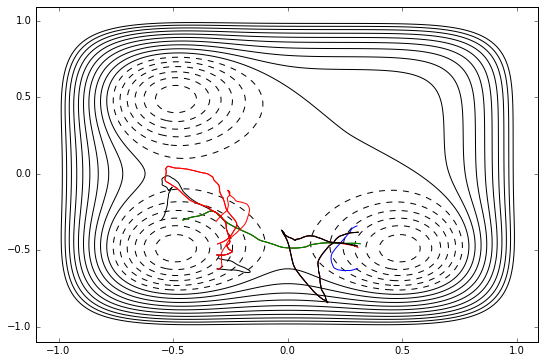

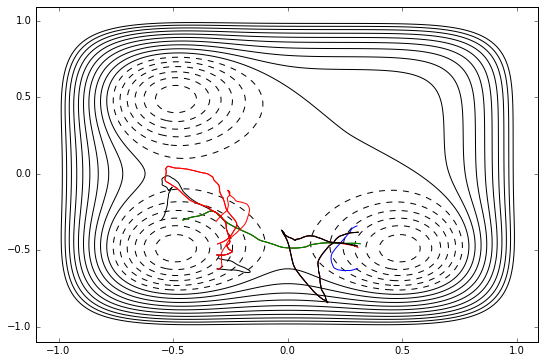

In [17]:
plot.plot([s.trajectory for s in list(init_AB)+list(init_AC)+list(init_BA)])

In [18]:
# TODO: it would be really nice if all of this could be handled somewhat automatically
samples = []
trans2trajs = {tisAB : init_AB, tisAC : init_AC, tisBA : init_BA}
for trans in trans2trajs.keys():
    new_trans = mistis.transition_to_sampling[trans]
    for i in range(len(new_trans.ensembles)):
        samples.append(paths.Sample(
                trajectory=trans2trajs[trans][i].trajectory,
                ensemble=new_trans.ensembles[i],
                replica=len(samples)
        ))
sset = paths.SampleSet(samples)
sset.sanity_check()

outer_sset = paths.SampleSet([init.samples[-1] for init in [init_AB, init_BA]])
outer_sample = paths.Sample(
    replica=len(sset),
    trajectory=init_AB.samples[-1].trajectory,
    ensemble=mistis.ms_outers[0]
)
sset = sset.apply_samples([outer_sample])
sset.sanity_check()

minus_samples = []
for minus in mistis.minus_ensembles:
    for partial_traj in [s.trajectory for s in sset]:
        if minus._segment_ensemble(partial_traj):
            break
    #print minus._segment_ensemble(partial_traj)
    good_sample = False
    while not good_sample:
        samp = minus.populate_minus_ensemble(
            partial_traj=partial_traj,
            minus_replica_id=-mistis.minus_ensembles.index(minus)-1,
            engine=toy_eng
        )
        good_sample = samp.ensemble(samp.trajectory)
    minus_samples.append(samp)

sset = sset.apply_samples(minus_samples)
sset.sanity_check()

In [19]:
#logging.config.fileConfig("debug_logging.conf", disable_existing_loggers=False)
storage = paths.Storage("mistis.nc", "w", template=template)

In [20]:
mistis_calc = paths.PathSampling(
    storage=storage,
    engine=toy_eng,
    move_scheme=paths.DefaultScheme(mistis),
    globalstate=sset
)
mistis_calc.save_frequency = 100

In [21]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

mistis_calc.run_until(300)

Working on Monte Carlo cycle number 300.

DONE! Completed 300 Monte Carlo cycles.

